## K-SVD Algorithm

Based on the implementation of IshitaTakeshi.

In [5]:
using Pkg
Pkg.add("PyCall")
Pkg.add("DataStructures")
Pkg.add("SparseArrays")
Pkg.add("ProgressBars")
Pkg.add("DelimitedFiles")
Pkg.add("Plots")
Pkg.add("Images")
using DataStructures
using SparseArrays
using LinearAlgebra
using ProgressBars
using PyCall
using Plots


 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Res

In [11]:
function init_dictionary(n::Int, K::Int)
    """
    Initialize the dictionary.
    Args: 
        n: dimension of input signal
        k = number of atoms in the dictionary
    """
    # D must be a full-rank matrix
    D = rand(n, K)
    while rank(D) != min(n, K)
        D = rand(n, K)
    end

    @inbounds for k in 1:K
        D[:, k] ./= norm(@view(D[:, k]))
    end
    return D
end

init_dictionary (generic function with 1 method)

In [12]:
# The implementation is referencing the wikipedia page
# https://en.wikipedia.org/wiki/Matching_pursuit#The_algorithm

const default_max_iter = 20
const default_tolerance = 1e-6


function SparseArrays.sparsevec(d::DefaultDict, m::Int)
    SparseArrays.sparsevec(collect(keys(d)), collect(values(d)), m)
end


function matching_pursuit_(data::AbstractVector, dictionary::AbstractMatrix,
                           max_iter::Int, tolerance::Float64)
    n_atoms = size(dictionary, 2)

    residual = copy(data)

    xdict = DefaultDict{Int, Float64}(0.)
    for i in 1:max_iter
        if norm(residual) < tolerance
            return sparsevec(xdict, n_atoms)
        end

        # find an atom with maximum inner product
        products = dictionary' * residual
        _, maxindex = findmax(abs.(products))
        maxval = products[maxindex]
        atom = dictionary[:, maxindex]

        # c is the length of the projection of data onto atom
        a = maxval / sum(abs2, atom)  # equivalent to maxval / norm(atom)^2
        residual -= atom * a

        xdict[maxindex] += a
    end
    return sparsevec(xdict, n_atoms)
end


"""
    matching_pursuit(data::Vector, dictionary::AbstractMatrix;
                     max_iter::Int = $default_max_iter,
                     tolerance::Float64 = $default_tolerance)
Find ``x`` such that ``Dx = y`` or ``Dx ≈ y`` where y is `data` and D is `dictionary`.
```
# Arguments
* `max_iter`: Hard limit of iterations
* `tolerance`: Exit when the norm of the residual < tolerance
```
"""
function matching_pursuit(data::AbstractVector, dictionary::AbstractMatrix;
                          max_iter::Int = default_max_iter,
                          tolerance = default_tolerance)

    if tolerance <= 0
        throw(ArgumentError("`tolerance` must be > 0"))
    end

    if max_iter <= 0
        throw(ArgumentError("`max_iter` must be > 0"))
    end

    if size(data, 1) != size(dictionary, 1)
        throw(ArgumentError(
            "Dimensions must match: `size(data, 1)` and `size(dictionary, 1)`."
        ))
    end

    matching_pursuit_(data, dictionary, max_iter, tolerance)
end


"""
    matching_pursuit(data::AbstractMatrix, dictionary::AbstractMatrix;
                     max_iter::Int = $default_max_iter,
                     tolerance::Float64 = $default_tolerance)
Find ``X`` such that ``DX = Y`` or ``DX ≈ Y`` where Y is `data` and D is `dictionary`.
```
# Arguments
* `max_iter`: Hard limit of iterations
* `tolerance`: Exit when the norm of the residual < tolerance
```
"""
function matching_pursuit(data::AbstractMatrix, dictionary::AbstractMatrix;
                          max_iter::Int = default_max_iter,
                          tolerance::Float64 = default_tolerance)
    K = size(dictionary, 2)
    N = size(data, 2)

    X = spzeros(K, N)

    for i in 1:N
        X[:, i] = matching_pursuit(
            vec(data[:, i]),
            dictionary,
            max_iter = max_iter,
            tolerance = tolerance
        )
    end
    return X
end

matching_pursuit

In [13]:
function K_SVD(Y,niter_KSVD,n_atoms)
    """
    Computes the K-SVD algorithm.
    
    Args:
    Y - 
    niter_KSVD: number of iterations for the algorithm
    n_atoms - number of atoms in the dictionary
    returns: Dictionary (D) and Sparse coefficients (X) 
    
    """
    D = init_dictionary(size(Y,1),n_atoms)
    X = matching_pursuit(Y,D)
    for i in ProgressBar(1:niter_KSVD)
        X = matching_pursuit(Y,D)
        for k=1:n_atoms
            Xk = X[k,:]
            all(iszero,Xk)&&continue
            wk = findall(!iszero,Xk)
            indices = [j for j=1:size(D,2) if j!=k]
            Ek = Y - D[:,indices]*X[indices,:]
            Ωk = sparse(wk,1:length(wk),ones(length(wk)),size(Y,2),length(wk))
            U, S, V= svd(Ek*Ωk, full=true)
            D[:,k]=U[:,1]
            X[k,wk] = V[:,1]*S[1]
        end
    end
    return D,X
end

K_SVD (generic function with 1 method)

 ### First Task: Image Compression _(MNIST dataset)_

In [ ]:
datasets = pyimport("sklearn.datasets")
digits = datasets.load_digits()
Y = digits["data"];

In [ ]:
D,X = K_SVD(Y,200,256);

In [ ]:
# Find D and X such that Y ≈ DX

println("||Y - D * X|| = $(norm(Y - D * X))")

println("The ratio of zero elemnts in the matrix X: ",
        sum(X .== 0) / length(X))

In [ ]:
# saves result in a dlm file
using DelimitedFiles

writedlm("dictionary.dlm", D)
writedlm("reconstruction.dlm", D*X)

## Trying Generation in simple data

In [8]:
datasets = pyimport("sklearn.datasets")
function generate_circles(number_of_points_per_circle,number_of_circles)
    n_samples = convert(UInt8,(number_of_points_per_circle/2))
    result = zeros(number_of_points_per_circle,number_of_circles)
    for i = 1:number_of_circles
        circles = datasets.make_circles(n_samples=n_samples,noise=0.1)
        circles = reshape(circles[1],(n_samples*2))
        result[:,i] = circles
    end
    return result
end

generate_circles (generic function with 1 method)

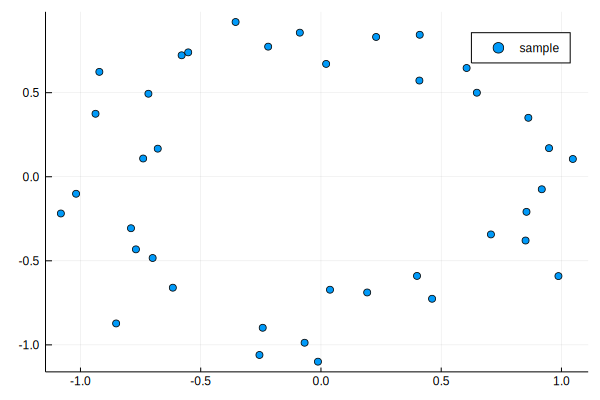

In [9]:
samples = generate_circles(80,100);
Plots.scatter(samples[:,40][1:40],samples[:,40][41:80],label="sample")

In [14]:
D,X = K_SVD(samples,200,20);

100.0%┣███████████████████████████████████████████████████████████┫ 200/200 [00:15<00:00, 13.6 it/s]


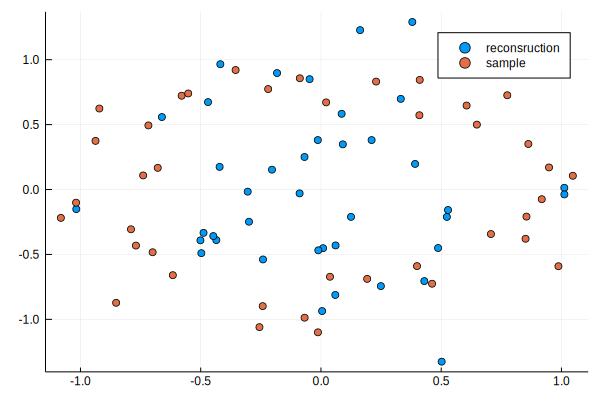

In [15]:
Plots.scatter((D*X)[:,40][1:40],(D*X)[:,40][41:80],label="reconsruction")
Plots.scatter!(samples[:,40][1:40],samples[:,40][41:80],label="sample")